In [71]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample
from pymc3.distributions.dist_math import bound
import theano.tensor as tt
import theano
import warnings
warnings.filterwarnings('ignore')
np.random.seed(seed=32)

In [72]:
%env THEANO_FLAGS=device=cpu,floatX=float32

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

from pymc3 import (
    NUTS,
    DensityDist,
    Dirichlet,
    Metropolis,
    MvNormal,
    Normal,
    Slice,
    find_MAP,
    sample,
)
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

print(f"Running on PyMC3 v{pm.__version__}")

env: THEANO_FLAGS=device=cpu,floatX=float32
Running on PyMC3 v3.11.5


In [73]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# WBIC for Gaussian Mixture Model with Pymc

The number of parameters (the number of clusters), can be evaluated statistically using *Beysian Information Criterion*.

Here we will apply WBIC, Widely applicable Bayes Information Criterion to Gaussian Mixture Model (GMM).

## Generation of toy data for simulation with GMM

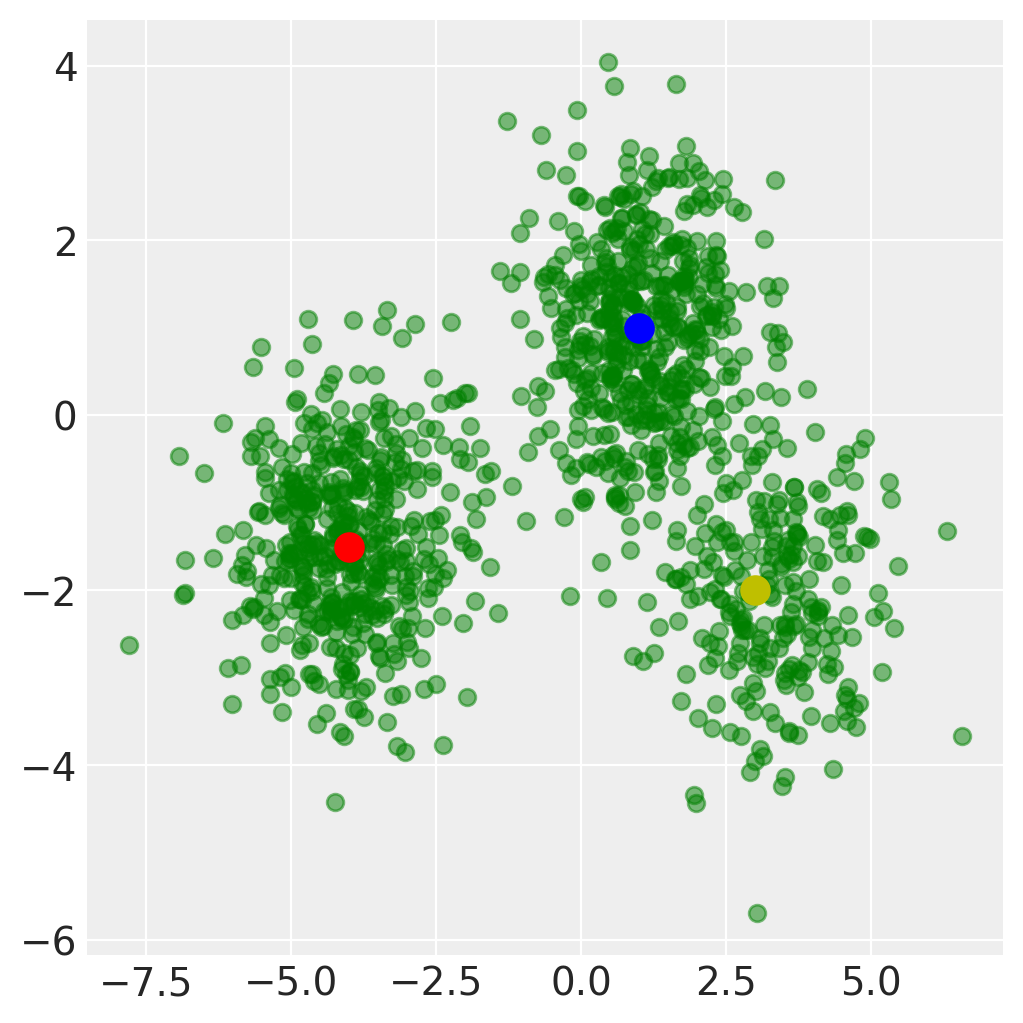

In [74]:
n_samples = 1200
N = n_samples
rng = np.random.RandomState(123)
ms = np.array([[-4, -1.5], [1, 1], [3, -2]])
ps = np.array([0.4, 0.4, 0.2])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [
    z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples) for z, m in zip(zs, ms)
]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c="g", alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c="r", s=100)
plt.scatter(ms[1, 0], ms[1, 1], c="b", s=100)
plt.scatter(ms[2, 0], ms[2, 1], c="y", s=100);

Samples assume that the three clusters are distributed in a two-dimensional space, as in the plot above.

In [120]:
data.shape #(sample size x dimension)

(1200, 2)

## Brief description of the Gaussian mixture model

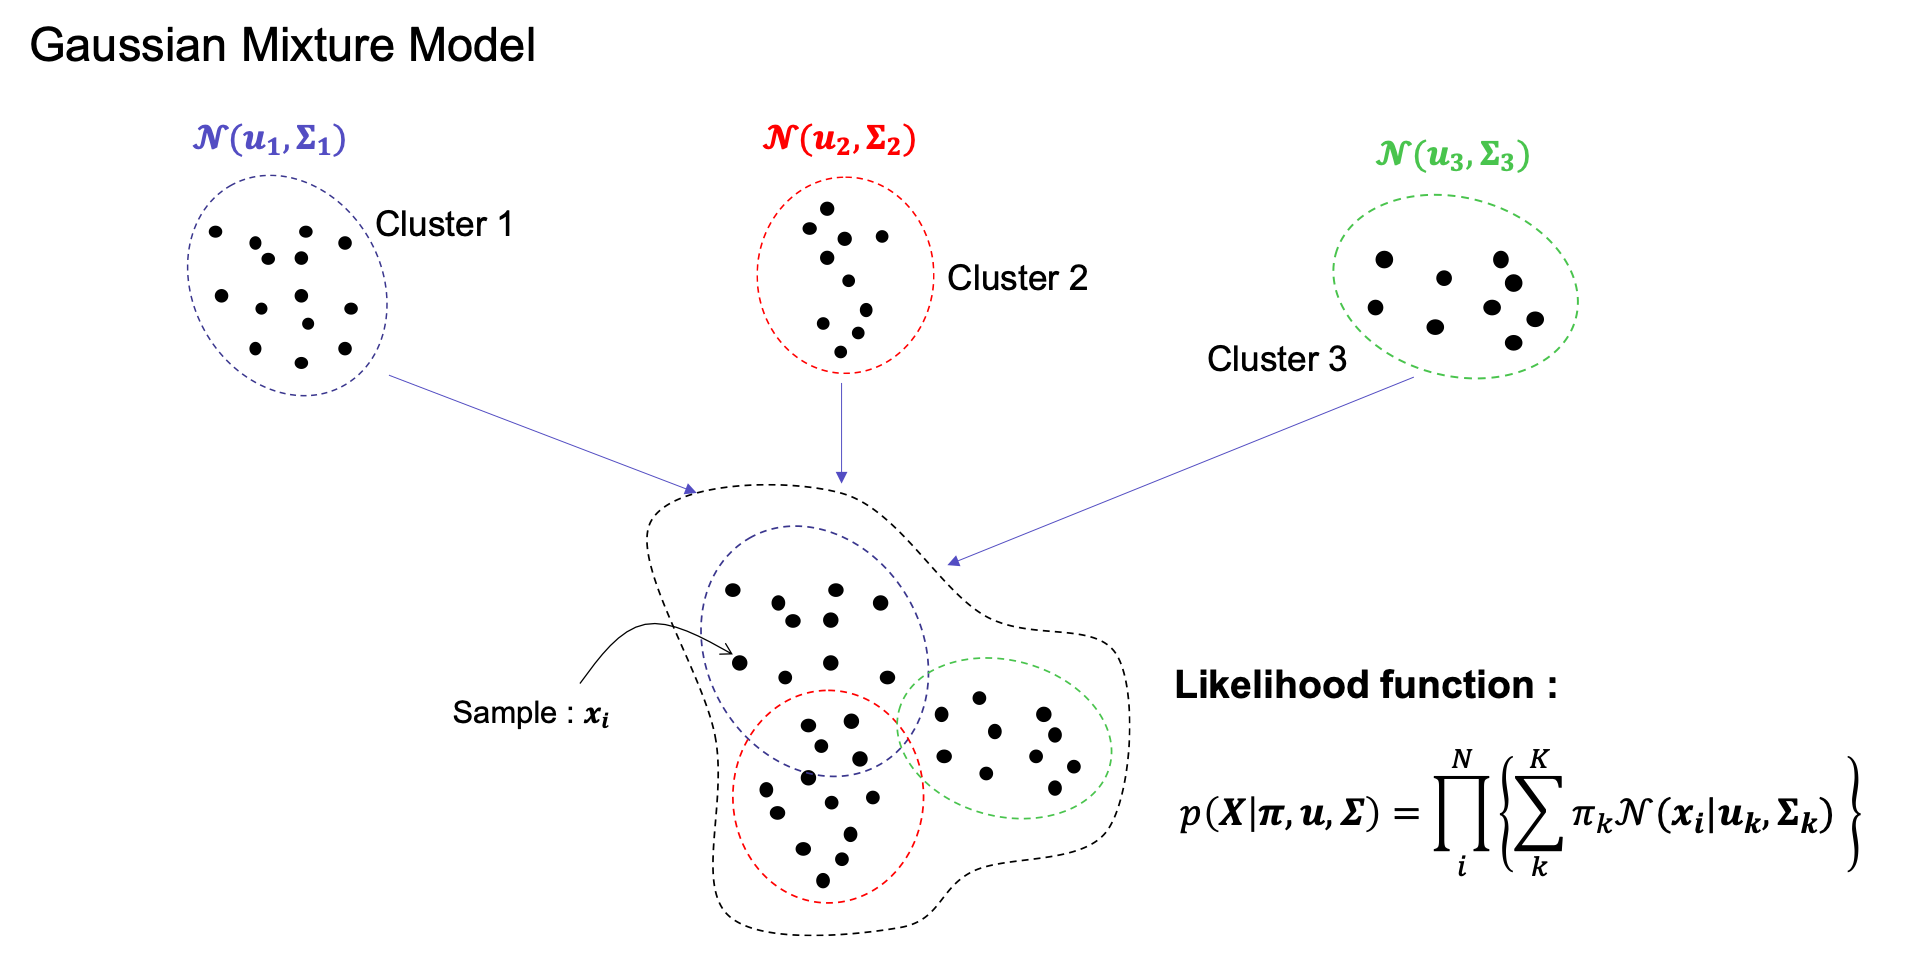

The Gaussian mixture model assumes that the probability distribution (model) representing the set of all samples is represented by a mixture (linear combination) of normal distributions representing several clusters, as shown in the figure above. <br>
$\pi_k$ is a parameter called the mixing coefficient, which is a variable that represents how much of each normal distribution is mixed.

<strong> What we want to know is how many clusters (normal distribution) from which the GMM is composed. </strong> <br>
<strong> The true parameter $K$ representing the number of clusters can be determined from WBIC for the GMM model.  </strong> 

## Brief description of WBIC

・ Evaluate free energy of the model by [WBIC](https://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf)

Given the observation $X = \{x_1, x_2, ..., x_i, ..., x_n\} \> (x_i 	\sim p(x))$, free energy of the model is defined as the negative-log-marginal-likelihood, namely,
$$
F(\{x_i\}) = -\log  \int \prod_i p(x_i|w) \phi(w) dw
$$

The expected value of free energy will be minimum when the prediction is equivalent with the *true* probability distibution $p(x)$.

Thus, smaller $F$ implies *better* model even considering all possible parameters.

Though it is difficult to obtain the integral over parameter space $w$, in general, Watanabe showed that $F$ can be approximated by "Widely applicable Bayesian Information Criterion (WBIC)", which is defined as below,

$$
F \simeq \mathrm{WBIC}
$$

\begin{eqnarray*}
\mathrm{WBIC} &=& E^\beta_w [F(w)] \> \> β = 1/\log n \\
E^\beta_w [F(w)] &=& \frac{1}{Z^\beta}\int F(w) \prod_i p(x_i|w)^{\beta} \phi(w) dw \\
Z^\beta &=& \int \prod_i p(x_i|w)^{\beta} \phi(w) dw\\
F(w) &=& - \sum_i \log p(x_i|w) \\ \\
\textrm{by Monte Carlo approximation} \\
\mathrm{WBIC} &=& E^\beta_w \left[-\sum_i \log p(x_i|w) \right], \> \> β = 1/\log n \\
&\simeq& \frac{1}{M} \sum_j \left\{\sum_i -\log p(x_i|w_j) \right\}, \> \> p(w_j| x) \propto \prod_i p(x_i|w)^{\beta} \phi(w) \\
&=& \frac{1}{M} \sum_j -\log p(X|w_j)  \ \cdots \ (1), \> \> w_j \sim p(w_j| X) \propto p(X|w)^{\beta} \phi(w) \ \cdots \ (2) \\
\end{eqnarray*}

$\bullet \ p(X|w)$ : likelihood function of model  <br>
$\bullet \ p(X|w)^{\beta}$ : likelihood function of model with inverse temperture ${\beta}$ <br>
$\bullet \ \phi(w)$ : prior distribution of model's parameters 

In practice, WBIC can be calculated simply by calculating the last equation (1). <br> <br> 
Eq.(1) is the expected value of $-\log p(X|w_j)$ with parameters $w_j$ from the Bayesian posterior distribution with inverse temperature Eq.(2). <br> 
It is necessary to sample $w_j$ from the Bayesian posterior distribution with inverse temperature $p(w_j| X)$ and to compute the likelihood $p(X|w_j)$ using $w_j$. <br>  <br> 
\begin{eqnarray*}
p(w_j| X) =  \frac{p(X|w)^{\beta} \phi(w)}{Z^\beta} \ \cdots \ (3)
\end{eqnarray*}  <br> 
This distribution cannot be obtained analytically, but samples $w_j$ from the posterior distribution can be generated numerically by MCMC. <br> 
Thus, the calculation is divided into two stages.

Step 1 ) : Sampling $w_j$ from Bayesian posterior distribution (3) by MCMC.  <br> 
Step 2 ) : Calculation of expected value Eq.(1) using parameters $w_j$ generated in step1. This expectation is equal to WBIC.

### Log likelihood function of GMM with Inverse Temperture (for MCMC)

definition : $\log p(X|w)^{\beta}$ <br>  <br> 
The parameters $w$ in the Gaussian mixture model (GMM) are the mean $\mu_k$ and  the covariance matrix $\sigma_k$, the mixture.coefficient $\pi_k$. <br>
$ p(X|w)$ : likelihood function of GMM is as follows
\begin{eqnarray*}
p(X| w) =  \prod_{i=1}^{n} \left\{\sum_{k=1}^{K}  \pi_k p(x_i|\mu_k, \sigma_k) \right\},
\end{eqnarray*}  <br> 
And $ p(X|w)^{\beta}$ : likelihood function of GMM with Inverse Temperture is as follows
\begin{eqnarray*}
p(X| w)^{\beta} =  \prod_{i=1}^{n} \left\{\sum_{k=1}^{K}  \pi_k p(x_i|\mu_k, \sigma_k) \right\}^{\beta}
\end{eqnarray*}  <br> 

In [76]:
# Log likelihood of normal distribution
def logp_normal_data(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )

def logp_gmm_invt(mus, pis, tau, beta = 1.0):
    def logp(value):
        logps = [tt.log(pis[i]) + logp_normal_data(mu, tau, value) for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :N], axis=0)) * beta

    return logp

## Step 1 ) MCMC sampling from Posterior Distribution with Inverse Temperture 
The calculation of WBIC by MCMC requires the definition of a prior distribution $\phi(w)$ of parameters. <br> 

Here, the multivariate standard distribution is set as the prior distribution for the parameter $\mu_k$ of the mean. <br>
Lewandowski-Kurowicka-Joe (lKJ) Cholesky distribution as a prior distribution of  $\sigma_k$ representing the covariance matrix.  <br>
Dirichlet distribution as a prior distribution of mixing coefficients $\pi_k$.

In [115]:
#The variable nk in this script represents the number of clusters. 
#Therefore, if you want to change the number of clusters, you only need to change this variable.
nk = 10 #estimated number of clusters

## DEFINE MODEL
nD = data.shape[1] #dimension of samples
beta = 1/np.log(N)

with pm.Model() as model:
    
    print("prior definition")
    
    pik = pm.Dirichlet('pi_k', a=pm.floatX(0.1 * np.ones(nk)), shape=(nk,))
    
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(nD)), tau=pm.floatX(0.1 * np.eye(nD)), shape=(nD,))
        for i in range(nk)
    ]

    
    sd_dist = pm.Exponential.dist(1.0, shape=nD)
    #sd_dist = pm.HalfNormal.dist(sd=10, shape=nD)
    
    chol, _, _ = pm.LKJCholeskyCov(
        "chol", n=nD, eta=2.0, sd_dist=sd_dist, compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))

    obs = dict()
    
    print("likelihood definition")
    
    xs = DensityDist("x", logp_gmm_invt(mus, pik, cov, beta = beta), observed=data)
    
    #MCMC method setting
    step = pm.Metropolis()
    
    print("MCMC Start")
    
    #MCMC run
    trace = pm.sample(500, step = step, chains = 2)

prior definition
likelihood definition


KeyboardInterrupt: 

### Log likelihood function of GMM (for WBIC)

definition 2 : $\log p(X|w)$ <br>

$ p(X|w)$ : likelihood function of GMM is as follows
\begin{eqnarray*}
p(X| w) =  \prod_{i=1}^{n} \left\{\sum_{k=1}^{K}  \pi_k p(x_i|\mu_k, \sigma_k) \right\}
\end{eqnarray*}  <br> 

In [108]:
from pymc3.math import logsumexp

# Log likelihood of normal distribution
def logp_normal_data(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )

# Log likelihood of Gaussian mixture distribution
def logp_gmm(mus, pis, tau):
    def logp(value):
        logps = [tt.log(pis[i]) + logp_normal_data(mu, tau, value) for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :N], axis=0))

    return logp

## Step 2 ) WBIC Calculation

Calculate WBIC using the parameters $w$ from the Bayesian posterior distribution with inverse temperature calculated in step 1.

In [109]:
with pm.Model() as model2:
    
    print("prior definition")
    
    pik = pm.Dirichlet('pi_k', a=pm.floatX(0.1 * np.ones(nk)), shape=(nk,))
    
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(nD)), tau=pm.floatX(0.1 * np.eye(nD)), shape=(nD,))
        for i in range(nk)
    ]
    
    sd_dist = pm.Exponential.dist(1.0, shape=nD)
    #sd_dist = pm.HalfNormal.dist(sd=10, shape=nD)
    
    chol, _, _ = pm.LKJCholeskyCov(
        "chol", n=nD, eta=2.0, sd_dist=sd_dist, compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    
    obs = dict()
    
    print("likelihood definition")
    
    xs = DensityDist("x", logp_gmm(mus, pik, cov), observed=data)
        
    log_likes = pm.Deterministic("log_likes", xs.logpt) # to calc wbic

prior definition
likelihood definition


The parameters $w_j$ of the Bayesian posterior distribution calculated in step 1 are in the trace. From likelihood of the model defined above, WBIC is calculated using trace.

In [110]:
with model2:
    ppc = pm.sample_posterior_predictive(trace, var_names=["log_likes"])

In [111]:
ppc["log_likes"].shape

(1000,)

In [112]:
def wbic(log_likelihoods):
    return - np.mean(log_likelihoods)

We can get WBIC from wbic(ppc["log_likes"]) <br>
We can examine wbic for a different number of clusters by changing the value of the hyperparameter nk in step1.

Below are the results of the WBIC calculations for each different number of clusters, varying the number of nk (k=).

In [85]:
print("model (k=2)｜WBIC = {:.3f}".format(wbic(ppc["log_likes"])))

model (k=2)｜WBIC = 4889.711


In [92]:
print("model (k=3)｜WBIC = {:.3f}".format(wbic(ppc["log_likes"])))

model (k=3)｜WBIC = 4650.659


In [99]:
print("model (k=4)｜WBIC = {:.3f}".format(wbic(ppc["log_likes"])))

model (k=4)｜WBIC = 4652.285


In [106]:
print("model (k=5)｜WBIC = {:.3f}".format(wbic(ppc["log_likes"])))

model (k=5)｜WBIC = 4653.804


In [113]:
print("model (k=10)｜WBIC = {:.3f}".format(wbic(ppc["log_likes"])))

model (k=10)｜WBIC = 4655.927


WBIC was the smallest when the cluster number was k=3, it implies the three cluster model is the best likelihood even averaging all possible parameter spaces (less overfitting).